In [2]:
import pyemma
import pyemma.coordinates as coor

import mdtraj as md
from pprint import pprint
import glob, os, shutil, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from collections import Counter

import deeptime as dt
from deeptime.markov.hmm import BayesianHMM
from deeptime.clustering import BoxDiscretization
from deeptime.clustering import RegularSpace


## Extract the data and save into data.pkl

In [1]:
import os
import shutil

# Define the directory path
directory = "omega_data/"
clean_dir = False

# Handle directory creation and cleanup
try:
    if clean_dir:
        if os.path.exists(directory):
            # Remove all contents of the directory
            shutil.rmtree(directory)
            print(f"All contents in '{directory}' have been cleared.")
        # Recreate the empty directory
        os.makedirs(directory, exist_ok=True)
        print(f"Directory '{directory}' has been created/recreated.")
    else:
        # Ensure the directory exists without cleaning
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Directory '{directory}' did not exist, so it has been created.")
        else:
            print(f"Directory '{directory}' already exists. No action taken.")
except OSError as e:
    print(f"Error handling directory '{directory}': {e}")

Directory 'omega_data/' already exists. No action taken.


In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

## Featurization

In [29]:
traj_dir = '../PROJ12463traj_inte'
peptoid_gro = 'single_peptoid.gro'

files = []
run_list = []
for r in range(8):
    i = 0  # Counter for valid files for this 'r'
    for c in range(100):
        file = f"{traj_dir}/r{r}c{c}_inte.xtc"
        if os.path.exists(file):
            files.append(file)
            i += 1  # Correct increment
    run_list.append(i)
    
print('files', files)
print('run_list', run_list)
feat = pyemma.coordinates.featurizer(peptoid_gro)


files ['../PROJ12463traj_inte/r0c0_inte.xtc', '../PROJ12463traj_inte/r0c1_inte.xtc', '../PROJ12463traj_inte/r0c2_inte.xtc', '../PROJ12463traj_inte/r0c3_inte.xtc', '../PROJ12463traj_inte/r0c4_inte.xtc', '../PROJ12463traj_inte/r0c5_inte.xtc', '../PROJ12463traj_inte/r0c6_inte.xtc', '../PROJ12463traj_inte/r0c7_inte.xtc', '../PROJ12463traj_inte/r0c8_inte.xtc', '../PROJ12463traj_inte/r0c9_inte.xtc', '../PROJ12463traj_inte/r0c10_inte.xtc', '../PROJ12463traj_inte/r0c11_inte.xtc', '../PROJ12463traj_inte/r0c12_inte.xtc', '../PROJ12463traj_inte/r0c13_inte.xtc', '../PROJ12463traj_inte/r0c14_inte.xtc', '../PROJ12463traj_inte/r0c15_inte.xtc', '../PROJ12463traj_inte/r0c16_inte.xtc', '../PROJ12463traj_inte/r0c17_inte.xtc', '../PROJ12463traj_inte/r0c18_inte.xtc', '../PROJ12463traj_inte/r0c19_inte.xtc', '../PROJ12463traj_inte/r0c20_inte.xtc', '../PROJ12463traj_inte/r0c21_inte.xtc', '../PROJ12463traj_inte/r0c22_inte.xtc', '../PROJ12463traj_inte/r0c23_inte.xtc', '../PROJ12463traj_inte/r0c24_inte.xtc', '..

In [19]:
## Select feature 
CA_CA = feat.select(f'name == CA')

omega_atoms = [
    [6, 7, 18, 36],
    [36, 39, 41, 45],
    [45, 46, 57, 75]
]
# Convert to numpy array, subtract 1, and convert back to list (if required)
omega_atoms = np.array(omega_atoms) - 1
omega_atoms = omega_atoms.tolist()  


noe_atoms = [
    [16, 20],
    [16, 21],
    [17, 20],
    [17, 21],
    [37, 55],
    [37, 56],
    [38, 55],
    [38, 56]
]

# Convert to numpy array, subtract 1, and convert back to list (if required)
noe_atoms = np.array(noe_atoms) - 1
noe_atoms = noe_atoms.tolist()  

In [20]:
save_dir = 'omega_data'
feat.add_dihedrals(omega_atoms,deg=True) # Select the backbone omega angles 
np.save(f"{save_dir}/features", feat)
print(f"Features save at: {save_dir}/features.npy")

all_features = feat.describe()  # `describe()` should list all feature descriptions
for i, feature in enumerate(all_features):
    print(i+1, feature)

Features save at: omega_data/features.npy
1 DIH: Q03 2 CA 5 - Q03 2 C 6 - R07 3 N 17 - R07 3 CA 35 
2 DIH: R07 3 CA 35 - R07 3 C 38 - Q03 4 N 40 - Q03 4 CA 44 
3 DIH: Q03 4 CA 44 - Q03 4 C 45 - R07 5 N 56 - R07 5 CA 74 


In [21]:
data = coor.load(files, features=feat)
print('type of data:', type(data))
print('lengths:', len(data))
print('shape of elements:', data[0].shape)1
print('n_atoms:', feat.topology.n_atoms)

100%|██████████| 742/742 [11:32<00:00,  1.07it/s]                                 

type of data: <class 'list'>
lengths: 742
shape of elements: (345495, 3)
n_atoms: 82


In [23]:
save_dir = 'omega_data'
data_object = Data(data)
data_object.save(f"{save_dir}/data.pkl")
print(f"Data save at: {save_dir}/data.pkl")

Data save at: omega_data/data.pkl


## Combine the omega into one large traj, and plot them

In [3]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [25]:
save_dir = 'omega_data'
omega=Data.load(f"{save_dir}/data.pkl").array_list # This is an (716, x, 3) array
combined_omega = np.vstack(omega)
combined_omega = (combined_omega + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

print(f"The shape of combined_omega is {combined_omega.shape}")
print(combined_omega[:5])

The shape of combined_omega is (90475004, 3)
[[  0.8386154 -14.87294     7.269615 ]
 [-15.203705   20.326454  -13.589485 ]
 [-22.90915    31.408813    5.9437637]
 [  8.2462845  -4.0880814  11.296898 ]
 [ 26.088242   13.688004  -17.914215 ]]


In [26]:
nsnaps = combined_omega[1]
print(nsnaps)

[-15.203705  20.326454 -13.589485]


## Load the omega, and separate them by the starting config

(742,)


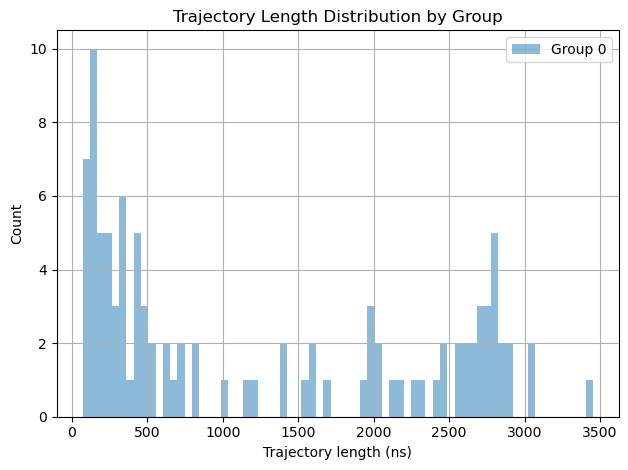

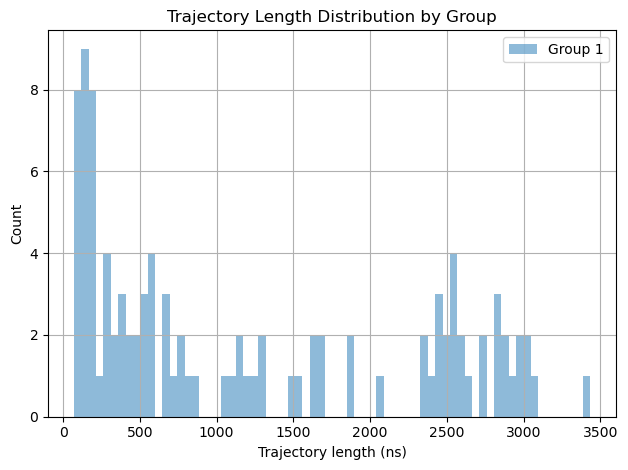

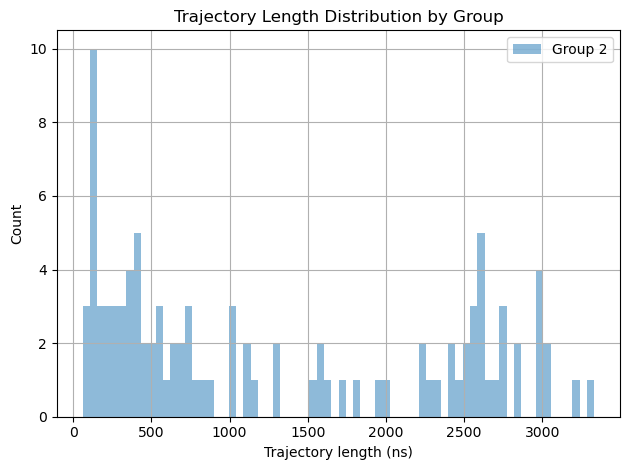

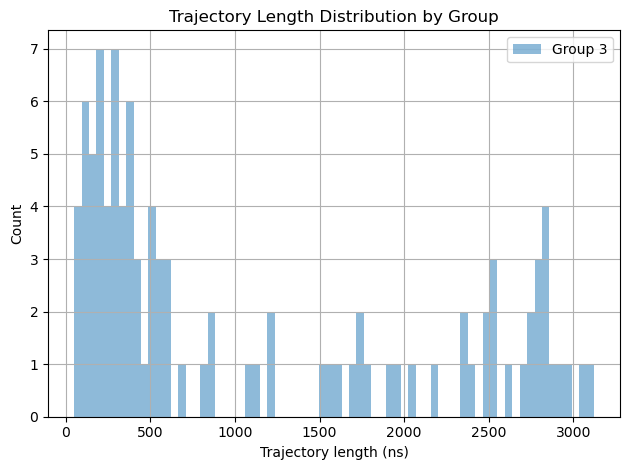

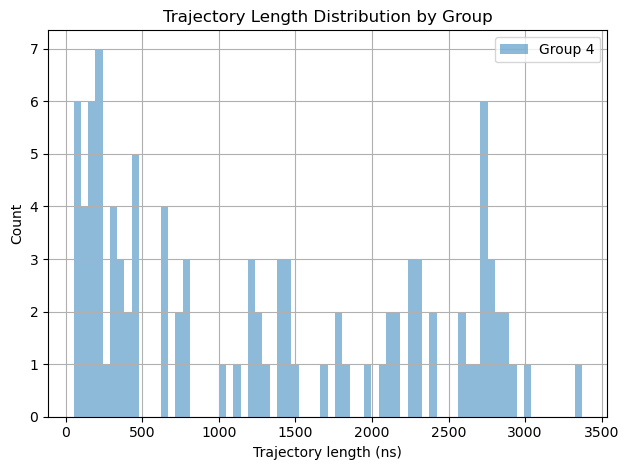

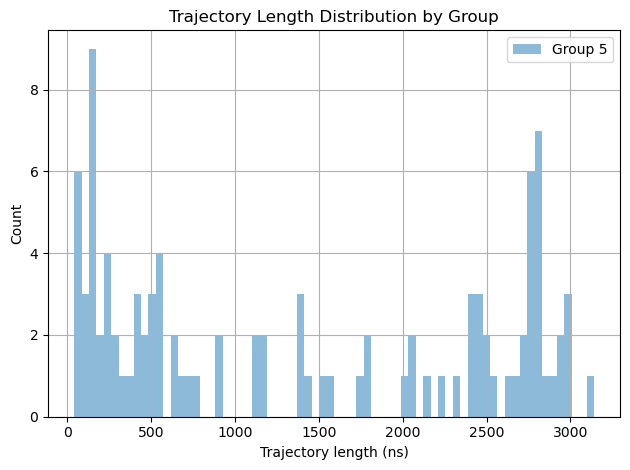

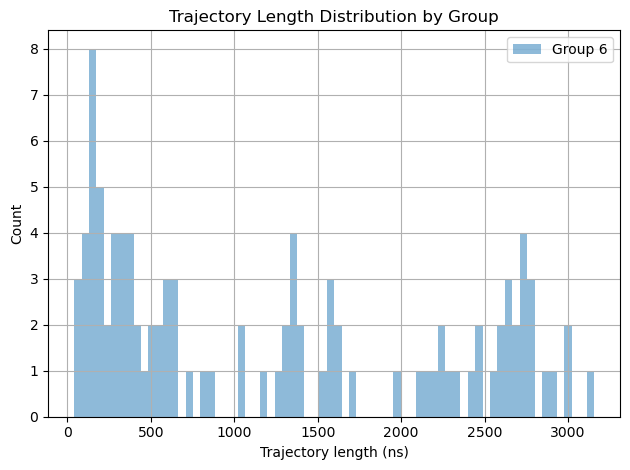

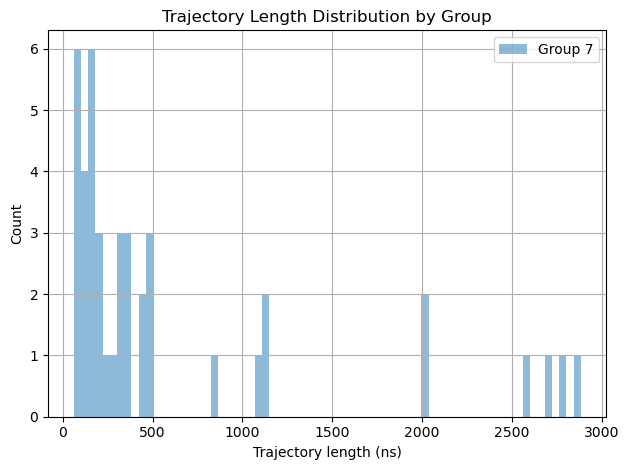

In [5]:
save_dir = 'omega_data'

omega=Data.load(f"{save_dir}/data.pkl").array_list # This is an (716, x, 3) array

traj_lens = [traj.shape[0] for traj in omega]
traj_lens = np.array(traj_lens)
print(traj_lens.shape)

for i in range(8):
    start = i * 100
    end = (i + 1) * 100 if (i + 1) * 100 <= len(traj_lens) else len(traj_lens)
    
    group = traj_lens[start:end] * 0.01  # Convert to ns
    
    plt.hist(group, bins=70, alpha=0.5, label=f'Group {i}')

    plt.xlabel("Trajectory length (ns)")
    plt.ylabel("Count")
    plt.title("Trajectory Length Distribution by Group")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
# Get trajectory lengths
traj_lens = np.array([traj.shape[0] for traj in omega])
print('traj_lens.shape :', traj_lens.shape)

# Group into 8 groups: 7 of size 100, 1 of size 42
grouped_traj_lens = {}
group_size = 100
num_full_groups = 7

# Step 1: Split and store original indices
for i in range(num_full_groups):
    start = i * group_size
    end = (i + 1) * group_size
    group_indices = np.arange(start, end)
    grouped_traj_lens[f'group_{i}'] = (group_indices, traj_lens[start:end])

# Final group (rest)
start = num_full_groups * group_size
group_indices = np.arange(start, len(traj_lens))
grouped_traj_lens[f'group_{num_full_groups}'] = (group_indices, traj_lens[start:])

# Step 3: Calculate sum of each group before filtering
print("\nSum of trajectory lengths per group (before filtering):")
for group_name, (_, lengths) in grouped_traj_lens.items():
    print(f"{group_name}: total length = {np.sum(lengths)}")


traj_lens.shape : (742,)

Sum of trajectory lengths per group (before filtering):
group_0: total length = 12533656
group_1: total length = 12207155
group_2: total length = 12831303
group_3: total length = 10984518
group_4: total length = 12913071
group_5: total length = 13997293
group_6: total length = 12343035
group_7: total length = 2664973


In [ ]:
S
filtered_groups = {}
total_length_sum = 0

for group_name, (indices, lengths) in grouped_traj_lens.items():
    if len(lengths) >= 50:
        # Filter out the 50 shortest
        sorted_idx = np.argsort(lengths)
        keep_idx = sorted_idx[90:]
        kept_indices = indices[keep_idx]
        kept_lengths = lengths[keep_idx]
    else:
        # Keep all
        kept_indices = indices
        kept_lengths = lengths
    
    filtered_groups[group_name] = (kept_indices, kept_lengths)
    total_length_sum += np.sum(kept_lengths)
    
    print(f"{group_name}: kept {len(kept_lengths)} trajectories, total length = {np.sum(kept_lengths)}")


group_0: kept 10 trajectories, total length = 2947549
group_1: kept 10 trajectories, total length = 3005411
group_2: kept 10 trajectories, total length = 3018372
group_3: kept 10 trajectories, total length = 2908736
group_4: kept 10 trajectories, total length = 2904285
group_5: kept 10 trajectories, total length = 2940286
group_6: kept 10 trajectories, total length = 2870436
group_7: kept 42 trajectories, total length = 2664973


Saved at: omega_data/Omega_angles_vs_Time_Plain_MD_in_19AE1-4-A.png


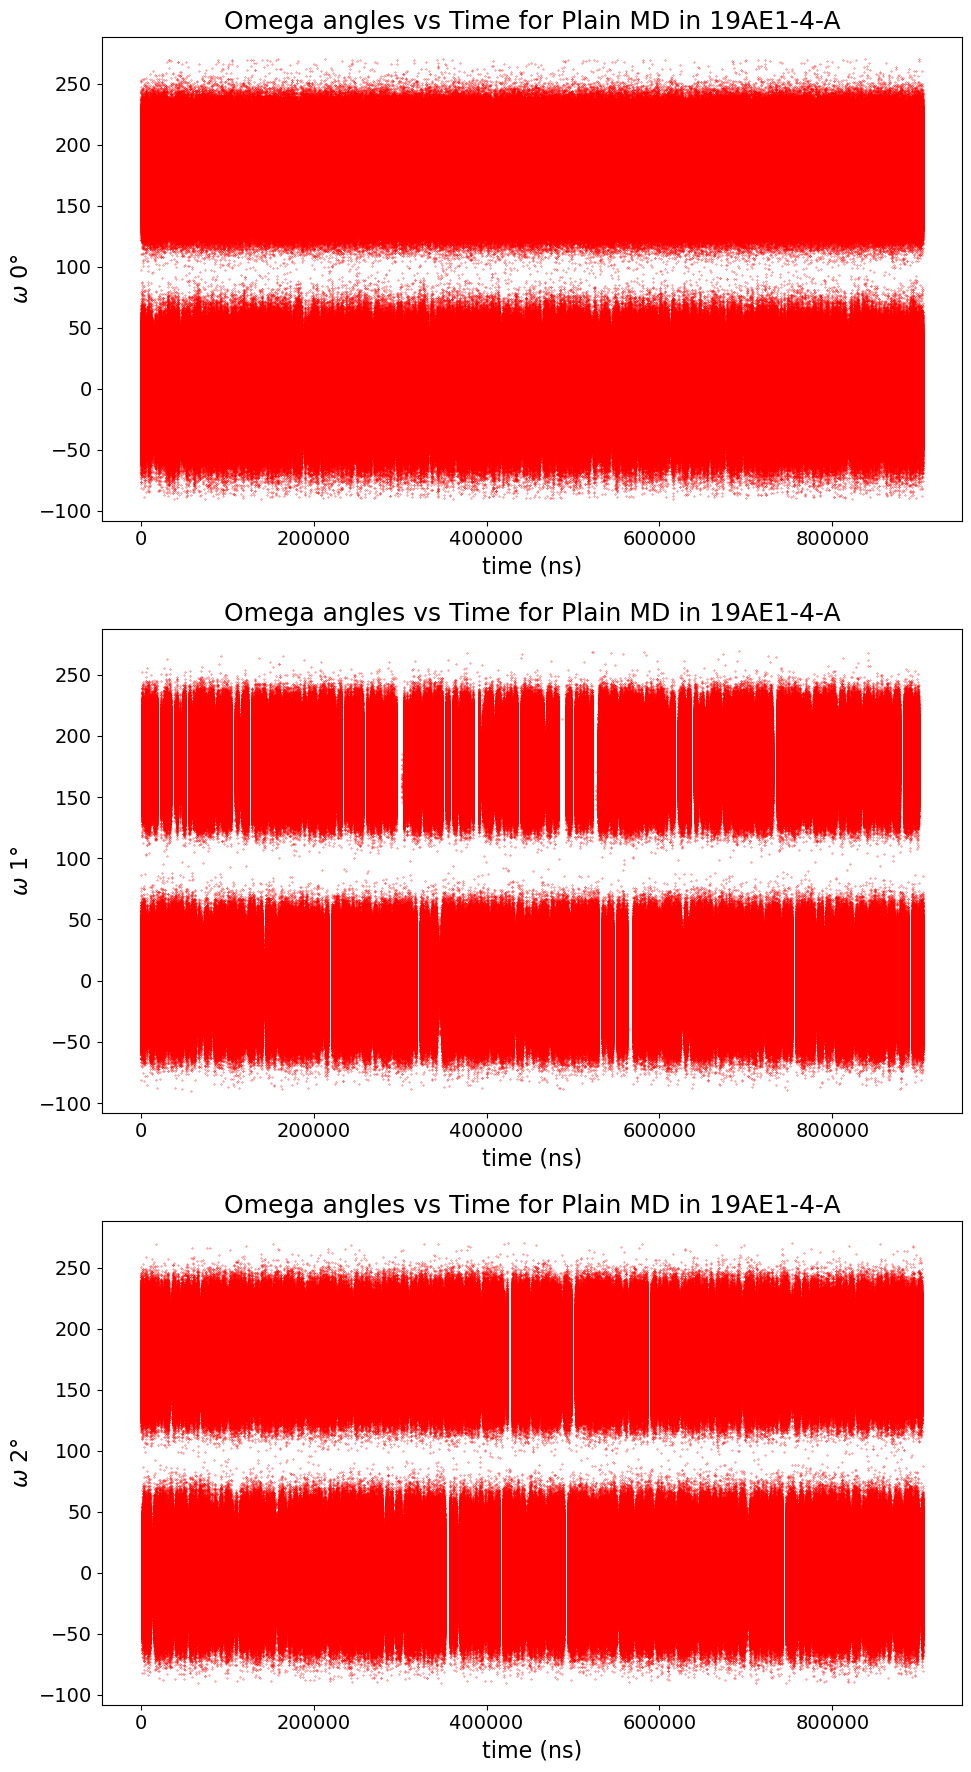

In [12]:
start = 0
nsnaps = combined_omega.shape[0]
t = np.arange(start, nsnaps) * 0.01 # Time axis in ns
step = 10000
downsampled_omega = combined_omega[start:nsnaps:step, :]  # Downsampled omega data

residues_to_plot = [0, 1, 2]
num_residues = len(residues_to_plot)

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

plt.figure(figsize=(10, 18))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, combined_omega[start:nsnaps, residue], '.', ms=0.5, color='red')
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ {residue}°')
    plt.title(f'Omega angles vs Time for Plain MD in 19AE1-4-A')

plt.tight_layout()

# Ensure the directory exists
outfilename = f'omega_data/Omega_angles_vs_Time_Plain_MD_in_19AE1-4-A.png'
plt.savefig(outfilename, transparent=True, dpi=600)
print(f"Saved at: {outfilename}")
#plt.show()

## Clustering

In [13]:
regularspace_estimator = RegularSpace(
    dmin=170,        # minimum distance between cluster centers, 180 degree
    max_centers=8,   # maximum number of cluster centers
    n_jobs=8,
)

In [14]:
# Fit the omegas data into model 
clustering = regularspace_estimator.fit(combined_omega).fetch_model()
assignments = clustering.transform(combined_omega)

print(clustering.cluster_centers)
print(f"Number of cluster centers: {len(clustering.cluster_centers)}")

[[ -5.1447678 -10.460213  167.95142  ]
 [178.76855    -6.5184174 155.63446  ]
 [199.87866   209.74911   207.34409  ]
 [ 16.467789  185.22339   160.99306  ]
 [-22.915977  188.2268    -29.303345 ]
 [151.76721   155.16162    27.115494 ]
 [ -5.1141434  17.413452  -26.175514 ]
 [196.90045   -39.36172   -14.8786545]]
Number of cluster centers: 8


In [15]:
## Assign each cluster center into cistrans 
cluster_center = clustering.cluster_centers
#print(cluster_center)

# Convert each value to "cis" or "trans"
cis_trans_labels = np.where(cluster_center < 90, "cis", "trans")

# Print results
for i, (center, labels) in enumerate(zip(cluster_center, cis_trans_labels)):
    print(f"Cluster {i}: {center} → {labels}")


Cluster 0: [ -5.1447678 -10.460213  167.95142  ] → ['cis' 'cis' 'trans']
Cluster 1: [178.76855    -6.5184174 155.63446  ] → ['trans' 'cis' 'trans']
Cluster 2: [199.87866 209.74911 207.34409] → ['trans' 'trans' 'trans']
Cluster 3: [ 16.467789 185.22339  160.99306 ] → ['cis' 'trans' 'trans']
Cluster 4: [-22.915977 188.2268   -29.303345] → ['cis' 'trans' 'cis']
Cluster 5: [151.76721  155.16162   27.115494] → ['trans' 'trans' 'cis']
Cluster 6: [ -5.1141434  17.413452  -26.175514 ] → ['cis' 'cis' 'cis']
Cluster 7: [196.90045   -39.36172   -14.8786545] → ['trans' 'cis' 'cis']


In [16]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())
cluster = []

for label, frequency in sorted_counts.items():    
    precentage = (frequency / total_counts) * 100 
    cluster.append(precentage)
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

outfile = 'clusters_probability.dat'
np.savetxt(outfile, cluster)

Assignment 0: 7091457, 7.838%
Assignment 1: 19782694, 21.87%
Assignment 2: 13457105, 14.87%
Assignment 3: 5831693, 6.446%
Assignment 4: 5930782, 6.555%
Assignment 5: 14362250, 15.87%
Assignment 6: 7498053, 8.287%
Assignment 7: 16520970, 18.26%


#### Plot the cluster 

In [ ]:
fig = plt.figure(figsize=(6, 10))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(combined_omega[:, 0], combined_omega[:, 1], combined_omega[:, 2], c=assignments[:], marker='.', alpha=0.05,cmap='tab20',label='STEPs')
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Label each cluster center
for i, (x, y, z) in enumerate(clustering.cluster_centers):
    ax1.text(x, y, z, f'Cluster {i}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(combined_omega[:, 0], combined_omega[:, 1], combined_omega[:, 2], c=assignments[:], marker='.', alpha=0.3 , cmap='tab20', label='STEPs')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(2.3, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(2.3, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_0$')
ax1.set_ylabel(r'$\omega_1$')
ax1.set_zlabel(r'$\omega_2$')

ax2.set_xlabel(r'$\omega_0$')
ax2.set_ylabel(r'$\omega_1$')
ax2.set_zlabel(r'$\omega_2$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png',transparent=True, dpi=600, bbox_inches='tight')
plt.show()

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_23618/1469998254.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


KeyboardInterrupt: 